# Based on [This](https://www.kaggle.com/code/vijay20213/stress-identification-nlp-with-best-prediction) Kaggle Notebook

# Setup

In [2]:
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'numpy'

# Data Preparation

## Initial Look & Keep Only Text, Target Label Columns

In [3]:
train_df=pd.read_csv('train.txt',delimiter=';',header=None,names=['text','label'])
stress_df=pd.read_csv('Stress.csv')

# Mapping dictionary
label_mapping = {'sadness': 1, 'fear': 1, 'anger': 1,'love':0,'joy':0,'surprise':0}

# Replace labels with 1 and others with 0
train_df['label'] = train_df['label'].replace(label_mapping)
train_df['label'].fillna(0, inplace=True)
stress_df=stress_df.iloc[:,3:5]


NameError: name 'pd' is not defined

In [4]:
raw_df=pd.concat([stress_df,train_df],ignore_index=True)

NameError: name 'pd' is not defined

In [4]:
raw_df.sample(n=5)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
1601,relationships,7sdyx6,"[100, 105]","Back to my dad, during lunch he wanted to say ...",0,0.571429,1516709505
2447,relationships,7o78rj,"(0, 5)",I’m a Canadian traveling in India and staying ...,0,1.000000,1515111891
1471,ptsd,9vaxit,"[0, 5]",November 8 is the anniversary of when I was ki...,1,0.800000,1541690897
2589,homeless,7r7wqs,"(11, 16)",I got as far as Illinois when he ghosted me af...,1,0.666667,1516258116
1956,relationships,7pg3a7,"(55, 60)",She didn’t have room for it where she was curr...,0,1.000000,1515596406


In [7]:
# raw_df.loc[1601, 'text']

"Back to my dad, during lunch he wanted to say some words to my GF, to encourage her to keep studying the doctorate, he said that if she felt that money was an issue, that don't let her that take her down, that doctorates in our country earn very poorly but that getting that degree would open doors to work abroad and land a job she would love. You see, my dad didn't know (well, I've told him plenty of times, but I figured he forgot at the time) that my GF's mom was a doctorate. My GF's mom openly told in front of my that she didn't earn enough for the years of study and work she did, everybody in our country knows that doctorates don't earn enough money for the effort, capacity and dedication they're required to do/have. But when my dad said those words, nobody said anything. I didn't take it as offensive."

In [3]:
# ignored_cols = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
# df = raw_df.drop(columns=ignored_cols)
# df.info()
df=raw_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2838 non-null   object
 1   label   2838 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.5+ KB


Relatively balanced starting dataset

In [9]:
df['label'].value_counts()

label
1    1488
0    1350
Name: count, dtype: int64

## Text Processing

### Packages Needed

from spacy import load --> errors

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from urllib.parse import urlparse

In [5]:
nltk.download('omw-1.4') # Open Multilingual Wordnet, this is an lexical database 
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/yichenzhang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/yichenzhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/yichenzhang/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/yichenzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yichenzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Pare Down Words - Token Level: Word

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))
'dont' in stop_words

False

In case of misspellings that leave out apostrophes:

In [7]:
print(len(stop_words))
for stopword in stop_words:
    if "'" in stopword:
        stop_words.append(re.sub("'", "", stopword))
print(len(stop_words))

179
205


In [8]:
stop_words = set(stop_words)
type(stop_words)

set

In [9]:
def process_text(sent, stopwords=stop_words):
    """Use RegEx to clean raw text data"""
    try:
        # brackets replacing by space
        sent = re.sub('[][)(]',' ',sent)

        # url removing
        sent = [word for word in sent.split() if not urlparse(word).scheme]
        sent = ' '.join(sent)

        # removing escap characters
        sent = re.sub(r"\@\w+", "", sent)

        # removing html tags 
        sent = re.sub(re.compile("<.*?>"),'',sent)

        # getting only characters and numbers from text
        sent = re.sub("[^A-Za-z0-9]",' ',sent)

        # lower case all words
        sent = sent.lower()
        
        # Remove extra whitespace between words
        sent = [word.strip() for word in sent.split()]
        sent = ' '.join(sent)

        # word tokenization
        tokens = word_tokenize(sent)
        
        # removing words which are in stopwords
        tokens = [t for t in tokens if t not in stopwords]
        
        # lemmatization
        sent = [lemmatizer.lemmatize(word) for word in tokens]
        sent = ' '.join(sent)
        return sent
    
    except Exception as ex:
        print(sent,"\n")
        print("Error ",ex)

In [10]:
df['processed_text'] = df['text'].apply(lambda text: process_text(text))
df.sample(n=3)

,text,label,processed_text
906,It sucks because I work on a computer and type...,1,suck work computer type day work needlepoint s...
920,I've been trying the online dating thing recen...,0,trying online dating thing recently met nice g...
526,"Not because I didn’t have evidence, but becaus...",1,evidence none evidence permissible court last ...


In [31]:
'than' in stop_words

True

In [34]:
lemmatizer.lemmatize('successfully')

'successfully'

In [11]:
sample_idx = 906
df.loc[sample_idx, 'text']

"It sucks because I work on a computer and type all day at work and do needlepoint and sewing as a hobby and I can't do those things when it's this bad. Of course when people (family, coworkers, friends) see the brace they ask what happened. I always blame carpal tunnel. I feel so angry that I am still covering up for my abuser. I am angry I can't e joy my life without him showing up randomly."

In [12]:
df.loc[sample_idx, 'processed_text']

'suck work computer type day work needlepoint sewing hobby thing bad course people family coworkers friend see brace ask happened always blame carpal tunnel feel angry still covering abuser angry e joy life without showing randomly'

In [35]:
from random import randint 

rand_index = randint(0, len(df)-1)
rand_index

464

SEEMINGLY RESOLVED: Not all the stopwords are being removed - possibility to improve here?

In [36]:
print("without process ---> ",df['text'].iloc[rand_index],end='\n\n')
print("after process ---> ",df['processed_text'].iloc[rand_index])

without process --->  My ex thought that show was terrific inspiration. He used it to discuss “what if”s with his guy friends, who I hope had no idea how real he is about that shit. I called it “The Rape Along/Beat Along Show” for the longest time. I still do when Gramma isn’t listening. Last time I unexpectedly came across the DVD set (Grampy accidentally left it at my place on the kitchen table, and, yes, he’d been told not to leave it where I might see it)...

after process --->  ex thought show terrific inspiration used discus guy friend hope idea real shit called rape along beat along show longest time still gramma listening last time unexpectedly came across dvd set grampy accidentally left place kitchen table yes told leave might see


### Vectorize (Word Embedding)

We may wish to set max_df instead of min_df.

Note: the reference notebook seems to have removed no words. We may not want to remove rare words, as they may be the most helpful in differentiating different texts, but we may not want to keep all the words, either, as they take up more resources.

| MIN_DF | Vocab Size |
| --- | --- |
| 0.01 | 666 |
| 0.001 | 3957 |
| 0.0001 | 10,126 |
| 0 | 10,126 |

In [13]:
MIN_DF = 0.001

#### Bag of Words (Count) Vectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
cv = CountVectorizer(min_df=MIN_DF)
cv_df = cv.fit_transform(df['processed_text'])
cv_df.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
cv_df = pd.DataFrame(cv_df.toarray(),columns=cv.get_feature_names_out())
cv_df.head(3)

,000,10,100,1000,10pm,10th,11,11th,12,120,...,york,young,younger,youngest,youth,youtube,yr,zero,zoloft,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Term Frequency, Inverse Document Frequency Vectorizer

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
tf = TfidfVectorizer(min_df=MIN_DF)
tf_df = tf.fit_transform(df['processed_text'])
tf_df.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.07822263, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
tf_df = pd.DataFrame(tf_df.toarray(),columns=tf.get_feature_names_out())
tf_df.head(3)

,000,10,100,1000,10pm,10th,11,11th,12,120,...,york,young,younger,youngest,youth,youtube,yr,zero,zoloft,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
tf_df.describe()

,000,10,100,1000,10pm,10th,11,11th,12,120,...,york,young,younger,youngest,youth,youtube,yr,zero,zoloft,zone
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,0.000677,0.003727,0.002011,0.000667,0.000229,0.000227,0.001028,0.000281,0.001725,0.000288,...,0.000279,0.002343,0.001621,0.000592,0.000308,0.000672,0.000891,0.000726,0.000812,0.000288
std,0.012414,0.024240,0.019533,0.012899,0.007261,0.007039,0.014251,0.007515,0.018149,0.007704,...,0.009003,0.019467,0.017246,0.011429,0.009648,0.012501,0.013893,0.012343,0.013497,0.008084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.417446,0.347310,0.323800,0.349854,0.284812,0.247687,0.274153,0.218368,0.376203,0.220154,...,0.383470,0.269158,0.260087,0.272226,0.364786,0.373744,0.276237,0.253284,0.366865,0.322071


In [65]:
cv_df.describe()

,000,10,100,1000,10pm,10th,11,11th,12,120,...,york,young,younger,youngest,youth,youtube,yr,zero,zoloft,zone
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,0.003524,0.025370,0.012333,0.003524,0.001057,0.001057,0.005638,0.001409,0.010571,0.001409,...,0.001057,0.015504,0.009866,0.002819,0.001057,0.003524,0.004228,0.003524,0.004228,0.001409
std,0.059266,0.161694,0.119582,0.070160,0.032501,0.032501,0.074886,0.037523,0.105678,0.037523,...,0.032501,0.126388,0.105746,0.053028,0.032501,0.064942,0.064899,0.059266,0.070121,0.037523
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000


# Build Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Either run this cell or the next, NOT both
random_seed = randint(0, 50)
random_seed

37

In [18]:
# Either run this cell or the above, NOT both
random_seed = 37

## BOW Embedding

In [19]:
# Default is 3:1 train:test
X_train, X_test, y_train, y_test = train_test_split(
    cv_df, df['label'], random_state=random_seed, stratify=df['label']
 )
X_train.shape, y_train.shape

((2128, 3957), (2128,))

In [20]:
X_test.shape, y_test.shape

((710, 3957), (710,))

### Logistic Regression

In [21]:
# Definitely overfitting
model_lr = LogisticRegression().fit(X_train,y_train)
model_lr.score(X_train,y_train),model_lr.score(X_test,y_test)

(0.9948308270676691, 0.719718309859155)

### Naive Bayes

In [71]:
# Test accuracy better, but still overfitting
model_nb = MultinomialNB().fit(X_train,y_train)
model_nb.score(X_train,y_train),model_nb.score(X_test,y_test)

(0.8923872180451128, 0.7352112676056338)

### Random Forest

In [72]:
# Surprising non-performant compared to the others
model_rf = RandomForestClassifier().fit(X_train,y_train)
model_rf.score(X_train,y_train),model_rf.score(X_test,y_test)

(0.9985902255639098, 0.6957746478873239)

## TF-IDF Embedding

In [73]:
X_train_td, X_test_td, y_train_td, y_test_td = train_test_split(
    tf_df, df['label'], random_state=random_seed, stratify=df['label']
)
X_train_td.shape, y_train_td.shape

((2128, 3957), (2128,))

In [75]:
X_test_td.shape, y_test_td.shape

((710, 3957), (710,))

### Logistic Regression

In [76]:
lr_td = LogisticRegression().fit(X_train_td, y_train_td)
lr_td.score(X_test_td, y_test_td)

0.7253521126760564

### Naive Bayes

In [77]:
nb_td = MultinomialNB().fit(X_train_td, y_train_td)
nb_td.score(X_test_td, y_test_td)

0.7295774647887324

### Random Forest

In [78]:
rf_td = RandomForestClassifier().fit(X_train_td, y_train_td)
rf_td.score(X_test_td, y_test_td)

0.6929577464788732

# Confusion Matrix & Classification Report

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [23]:
def get_confusion_matrix(predictions, test_target, plot_name):
    cm = confusion_matrix(predictions, test_target)
    print(cm)

    sns.heatmap(cm, annot=True, cmap='rocket_r', fmt='d')
    plt.title(plot_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def get_basic_report(model, features, target, plot_title):
    y_pred = model.predict(features)
    get_confusion_matrix(predictions=y_pred, test_target=target, plot_name=plot_title)
    print(classification_report(y_pred, target))

## Bag-of-Words Embedding

[[237  98]
 [101 274]]


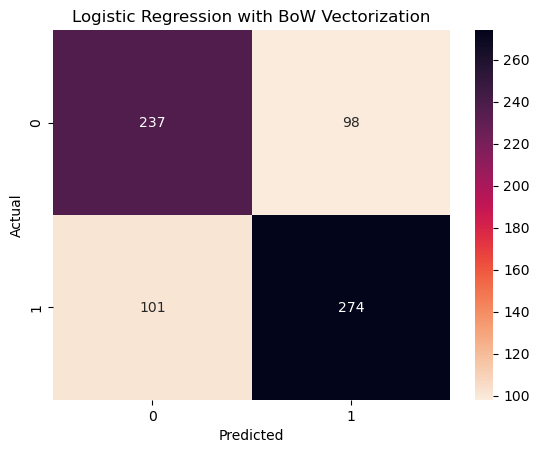

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       335
           1       0.74      0.73      0.73       375

    accuracy                           0.72       710
   macro avg       0.72      0.72      0.72       710
weighted avg       0.72      0.72      0.72       710



In [24]:
get_basic_report(model=model_lr, features=X_test, target=y_test, plot_title='Logistic Regression with BoW Vectorization')

[[222  72]
 [116 300]]


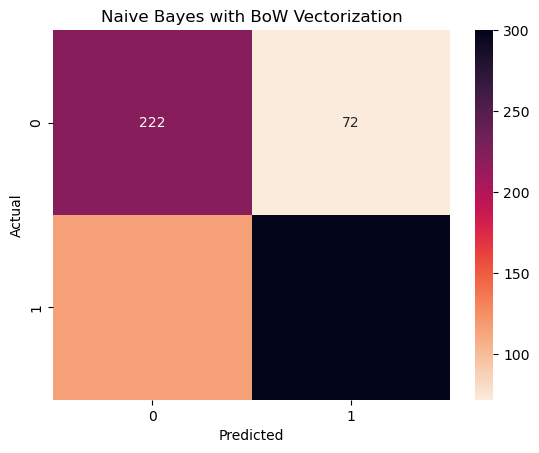

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       294
           1       0.81      0.72      0.76       416

    accuracy                           0.74       710
   macro avg       0.73      0.74      0.73       710
weighted avg       0.74      0.74      0.74       710



In [98]:
get_basic_report(model=model_nb, features=X_test, target=y_test, plot_title='Naive Bayes with BoW Vectorization')

[[202  80]
 [136 292]]


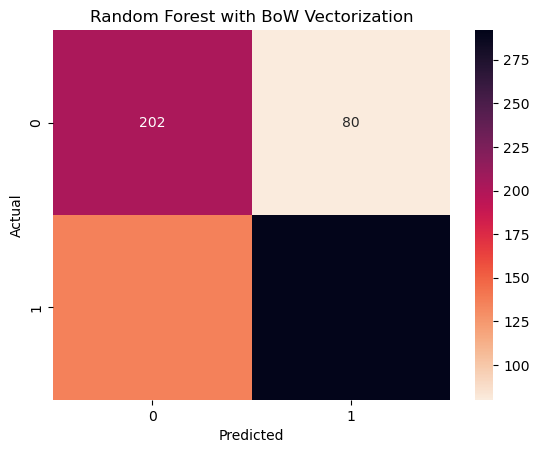

              precision    recall  f1-score   support

           0       0.60      0.72      0.65       282
           1       0.78      0.68      0.73       428

    accuracy                           0.70       710
   macro avg       0.69      0.70      0.69       710
weighted avg       0.71      0.70      0.70       710



In [99]:
get_basic_report(model=model_rf, features=X_test, target=y_test, plot_title='Random Forest with BoW Vectorization')

## TF-IDF Embedding

[[233  90]
 [105 282]]


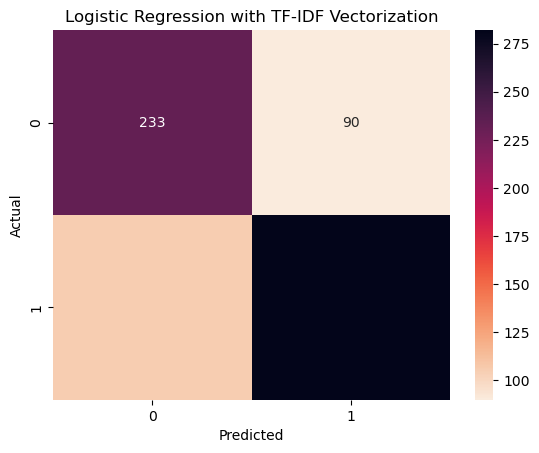

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       323
           1       0.76      0.73      0.74       387

    accuracy                           0.73       710
   macro avg       0.72      0.73      0.72       710
weighted avg       0.73      0.73      0.73       710



In [100]:
get_basic_report(model=lr_td, features=X_test_td, target=y_test_td, plot_title='Logistic Regression with TF-IDF Vectorization')

[[190  44]
 [148 328]]


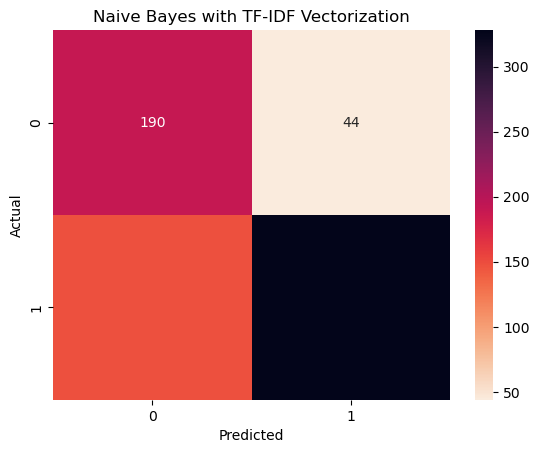

              precision    recall  f1-score   support

           0       0.56      0.81      0.66       234
           1       0.88      0.69      0.77       476

    accuracy                           0.73       710
   macro avg       0.72      0.75      0.72       710
weighted avg       0.78      0.73      0.74       710



In [101]:
get_basic_report(model=nb_td, features=X_test_td, target=y_test_td, plot_title='Naive Bayes with TF-IDF Vectorization')

[[201  81]
 [137 291]]


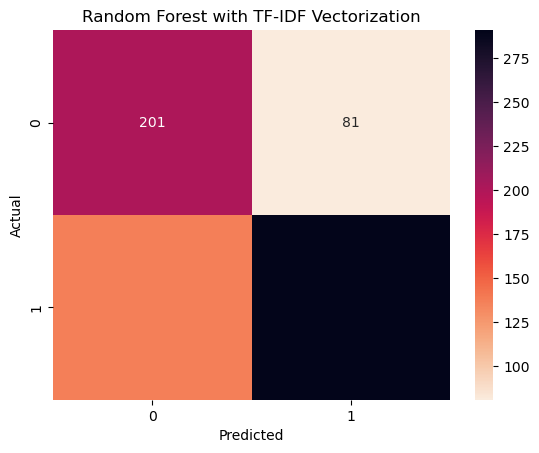

              precision    recall  f1-score   support

           0       0.59      0.71      0.65       282
           1       0.78      0.68      0.73       428

    accuracy                           0.69       710
   macro avg       0.69      0.70      0.69       710
weighted avg       0.71      0.69      0.70       710



In [103]:
get_basic_report(model=rf_td, features=X_test_td, target=y_test_td, plot_title='Random Forest with TF-IDF Vectorization')

# Predictions

Now use all as training data.

In [122]:
def predict_stress(text, model, vectorizer):
    output = 'Stress not detected'
    processed = process_text(text)
    embedded_words = vectorizer.transform([processed])
    res = model.predict(embedded_words)
    if res[0] == 1:
        output = "STRESS detected"
    return output

## Test Text

In [105]:
# Stressed
text1 = """This is the worst thing that happened to me today. I got less marks in my exam, 
            so it is not going to help me in my future."""

# Nope
text2 = """Hi Shashank sir, I gained a lot of knowledge from you for my future use. 
            This was a very fun journey for me. Thanks for boosting my confidence."""


# Stressed - the models all miss this, compared to the original notebook, which uses all words for vocabulary
text3 = """
User: Hi, I need help!

Chatbot: Of course, what can I assist you with?

User: I have a deadline tomorrow and I haven't even started on my project yet. I'm freaking out!

Chatbot: Okay, take a deep breath. Let's start by breaking down the project into smaller tasks. 
What do you need to do first?

User: I need to gather some research and data, but I don't even know where to start!

Chatbot: No problem. Let's begin by outlining the main points of your project, 

and then we can find the resources you need to complete each section. Can you tell me more about your project?

User: It's a marketing report for my boss. I need to analyze our competitors and come up with a new marketing strategy.

Chatbot: Great, that gives us a good starting point. 

Let's look for industry reports and market research that can give you insights into your competitors. 

And don't forget to take breaks and pace yourself as you work on each section. You got this!"""

# Nope
text4 = """
User: Hi there! How are you doing today?

Chatbot: Hello! I'm doing well, thanks for asking. How about you?

User: I'm doing pretty well too, thanks. I just wanted to ask you a question about your service.

Chatbot: Of course, I'm here to help. What can I assist you with?

User: I'm interested in learning more about your pricing options. Can you provide me with some information?

Chatbot: Absolutely! We have several different pricing plans depending on your needs. 

Would you like me to send you a link to our pricing page?

User: Yes, that would be great. Also, do you offer any discounts or promotions?

Chatbot: Yes, we do offer discounts for long-term contracts and for certain types of organizations. 

Would you like me to provide more details?

User: That would be helpful, thank you.

Chatbot: Sure thing! Our team can provide you with all the information you need to make an informed decision. 

Is there anything else I can help you with today?"""

# Stressed?
text5 = """Not sure what to do. Feeling hopeless."""

## TF-IDF Embeddings on Individual Examples

Bag of Words embeddings do not return the same number of features as needed.

In [137]:
cv.transform([text1])

<1x3 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [133]:
tf.transform([text1])

<1x3957 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [124]:
final_lr_td = LogisticRegression().fit(tf_df, df['label'])
final_lr_td.score(tf_df, df['label'])

0.8886539816772375

In [141]:
for t in [text1, text2, text3, text4, text5]:
    print(t[:min(len(t), 50)])
    print(predict_stress(text=t, model=final_lr_td, vectorizer=tf))
    print('\n')

This is the worst thing that happened to me today.
STRESS detected


Hi Shashank sir, I gained a lot of knowledge from 
Stress not detected



User: Hi, I need help!

Chatbot: Of course, what 
Stress not detected



User: Hi there! How are you doing today?

Chatbot
Stress not detected


Not sure what to do. Feeling hopeless.
STRESS detected




### Naive Bayes

In [142]:
final_nb_td = MultinomialNB().fit(tf_df, df['label'])
final_nb_td.score(tf_df, df['label'])

0.854122621564482

In [143]:
for t in [text1, text2, text3, text4, text5]:
    print(t[:min(len(t), 50)])
    print(predict_stress(text=t, model=final_nb_td, vectorizer=tf))
    print('\n')

This is the worst thing that happened to me today.
STRESS detected


Hi Shashank sir, I gained a lot of knowledge from 
Stress not detected



User: Hi, I need help!

Chatbot: Of course, what 
Stress not detected



User: Hi there! How are you doing today?

Chatbot
Stress not detected


Not sure what to do. Feeling hopeless.
STRESS detected




### Random Forest

In [144]:
final_rf_td = RandomForestClassifier().fit(tf_df, df['label'])
final_rf_td.score(tf_df, df['label'])

0.9985905567300916

In [145]:
for t in [text1, text2, text3, text4, text5]:
    print(t[:min(len(t), 50)])
    print(predict_stress(text=t, model=final_rf_td, vectorizer=tf))
    print('\n')

This is the worst thing that happened to me today.
STRESS detected


Hi Shashank sir, I gained a lot of knowledge from 
Stress not detected



User: Hi, I need help!

Chatbot: Of course, what 
Stress not detected



User: Hi there! How are you doing today?

Chatbot
Stress not detected


Not sure what to do. Feeling hopeless.
Stress not detected


